In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import subprocess
from preprocessing.quality_process import compute_file_metrics


In [2]:
# --- paths ---
jsonl_path = "output.jsonl"      # your input dataset
out_csv_path = "output/file_metrics.csv"

# --- load dataset ---
rows = []
with open(jsonl_path, "r", encoding="utf-8") as f:
    for line in f:
        rows.append(json.loads(line))

print(f"Loaded {len(rows)} rows")

# --- run quality_process.py for each row ---
results = []
for row in rows:
    results.append(
        compute_file_metrics(
            row["filename"],
            row["content"]
        )
    )

# --- save to CSV ---
df = pd.DataFrame(results)
df.to_csv(out_csv_path, index=False)
print(f"Saved {len(df)} results → {out_csv_path}")
df.head()


Loaded 2276 rows
Saved 2276 results → output/file_metrics.csv


,filename,sha1,bytes,lines,avg_line_len,max_line_len,non_ascii_ratio,binary_like,enc_total_matched,enc_max_run,enc_fraction,enc_hits_base64,enc_hits_hexbytes,enc_hits_unicode,num_tokens_lang,k_shingle,num_shingles,hexnum_ratio,num_tokens_model,junk_path
0,cryptol/bench/data/AES.cry,4278a57f5072036432bc1784cf3138d5189a8f5f,17154,258,65.49,4100,0.0,False,8204,4106,0.478256,2,0,0,2075,5,2071,0.004337,None,False
1,cryptol/bench/data/BigSequenceHex.cry,df79a89e3f6e83bae44419372c8d6cf09631ee3d,28677,1,28677.00,28677,0.0,False,0,0,0.000000,0,0,0,8195,5,8191,0.000000,None,False
2,cryptol/bench/data/BigSequence.cry,1caf8dc55a2c6362cf22c82b85dbb8d8226dbb1b,19377,2,9688.00,19376,0.0,False,270,270,0.013934,0,1,0,8195,5,8191,0.000000,None,False
3,cryptol/bench/data/ZUC.cry,88e477e242c2e72763152534f31c4a3d2db78fa9,11699,309,36.86,80,0.0,False,0,0,0.000000,0,0,0,2723,5,2719,0.029747,None,False
4,cryptol/bench/data/SHA512.cry,f6b562b76a3a09cc1f140da65bd72bc1e22725c9,4140,102,39.60,424,0.0,False,389,258,0.093961,2,0,0,830,5,826,0.108434,None,False


In [3]:
'''
df = pd.read_csv("output/file_metrics.csv")

# Remove a local directory from the "filename" column
df["filename"] = df["filename"].str.replace(
    "/Users/josh/SecurityAnalytics/development/", "", regex=False
)
df.info()
'''

'\ndf = pd.read_csv("output/file_metrics.csv")\n\n# Remove a local directory from the "filename" column\ndf["filename"] = df["filename"].str.replace(\n    "/Users/josh/SecurityAnalytics/development/", "", regex=False\n)\ndf.info()\n'

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2276 entries, 0 to 2275
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   filename           2276 non-null   object 
 1   sha1               2276 non-null   object 
 2   bytes              2276 non-null   int64  
 3   lines              2276 non-null   int64  
 4   avg_line_len       2276 non-null   float64
 5   max_line_len       2276 non-null   int64  
 6   non_ascii_ratio    2276 non-null   float64
 7   binary_like        2276 non-null   bool   
 8   enc_total_matched  2276 non-null   int64  
 9   enc_max_run        2276 non-null   int64  
 10  enc_fraction       2276 non-null   float64
 11  enc_hits_base64    2276 non-null   int64  
 12  enc_hits_hexbytes  2276 non-null   int64  
 13  enc_hits_unicode   2276 non-null   int64  
 14  num_tokens_lang    2276 non-null   int64  
 15  k_shingle          2276 non-null   int64  
 16  num_shingles       2276 

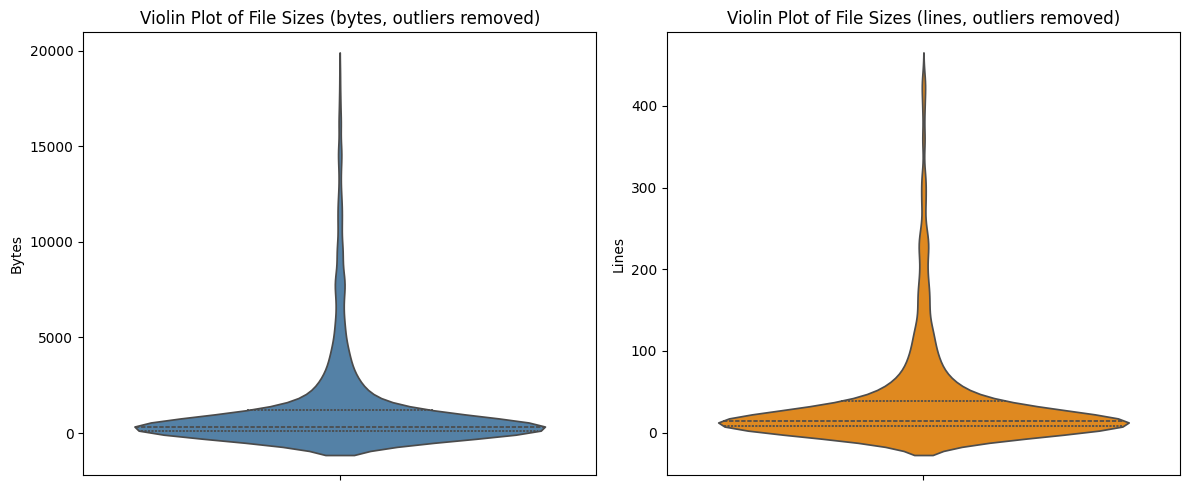

In [5]:
bytes_cutoff = df['bytes'].quantile(0.95)
lines_cutoff = df['lines'].quantile(0.95)

df_filtered = df[(df['bytes'] <= bytes_cutoff) & (df['lines'] <= lines_cutoff)]

plt.figure(figsize=(12,5))

# Violin plot for bytes
plt.subplot(1,2,1)
sns.violinplot(y=df_filtered['bytes'], color="steelblue", inner="quartile")
plt.title("Violin Plot of File Sizes (bytes, outliers removed)")
plt.ylabel("Bytes")

# Violin plot for lines
plt.subplot(1,2,2)
sns.violinplot(y=df_filtered['lines'], color="darkorange", inner="quartile")
plt.title("Violin Plot of File Sizes (lines, outliers removed)")
plt.ylabel("Lines")

plt.tight_layout()
plt.show()

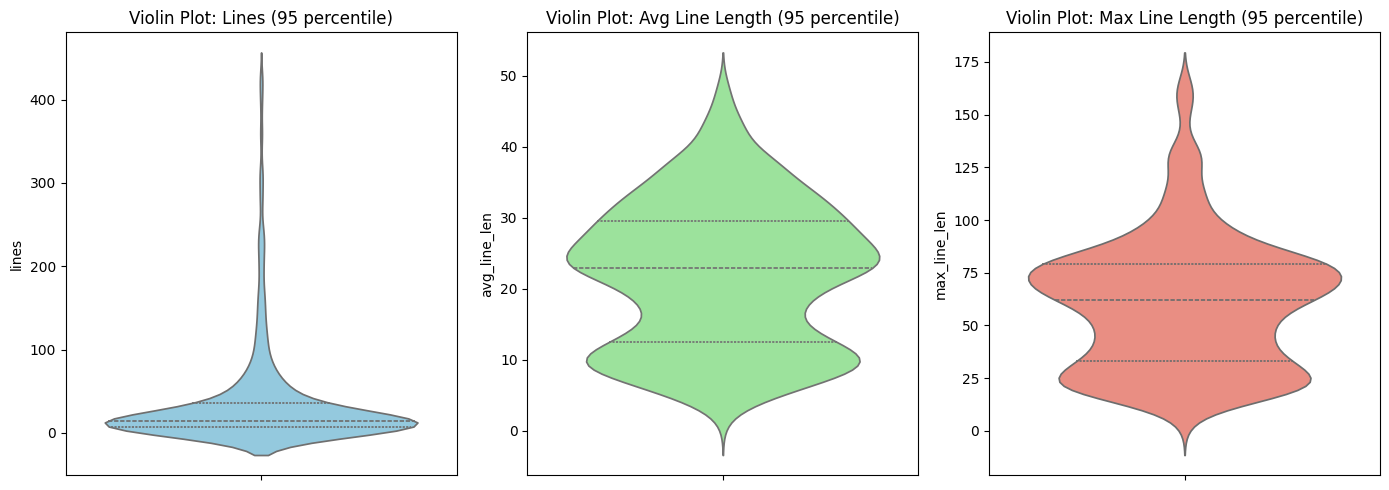

In [6]:
# Outlier clipping thresholds
lines_cut = df['lines'].quantile(0.95)
avg_cut   = df['avg_line_len'].quantile(0.95)
max_cut   = df['max_line_len'].quantile(0.95)

df_filtered = df[
    (df['lines'] <= lines_cut) &
    (df['avg_line_len'] <= avg_cut) &
    (df['max_line_len'] <= max_cut)
]

plt.figure(figsize=(14,5))

# Violin plot for lines
plt.subplot(1,3,1)
sns.violinplot(y=df_filtered['lines'], color="skyblue", inner="quartile")
plt.title("Violin Plot: Lines (95 percentile)")

# Violin plot for avg_line_len
plt.subplot(1,3,2)
sns.violinplot(y=df_filtered['avg_line_len'], color="lightgreen", inner="quartile")
plt.title("Violin Plot: Avg Line Length (95 percentile)")

# Violin plot for max_line_len
plt.subplot(1,3,3)
sns.violinplot(y=df_filtered['max_line_len'], color="salmon", inner="quartile")
plt.title("Violin Plot: Max Line Length (95 percentile)")

plt.tight_layout()
plt.show()


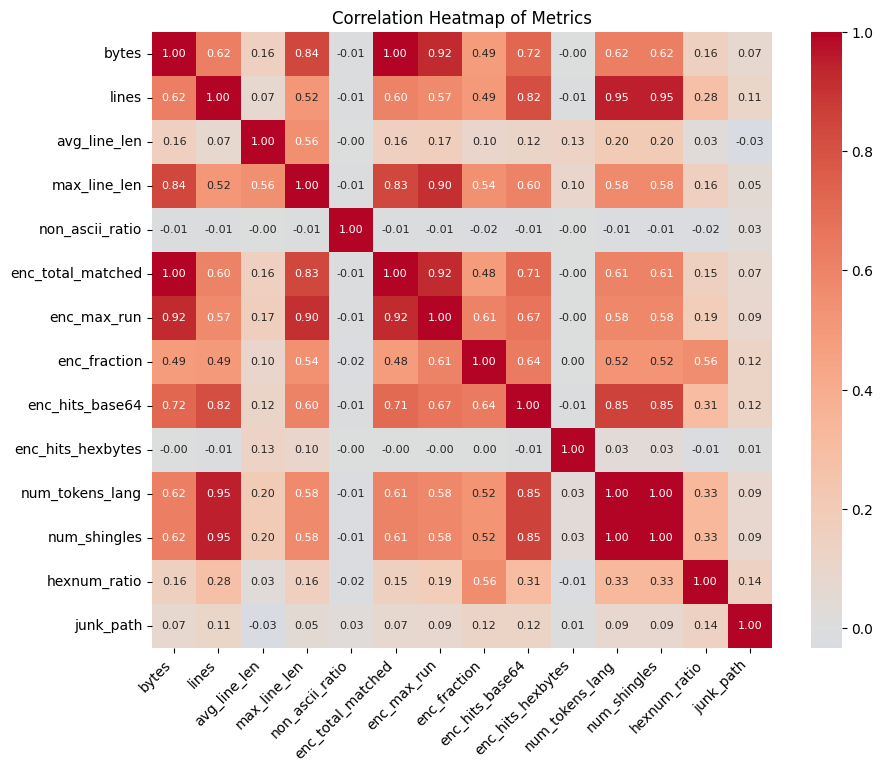

In [7]:
plt.figure(figsize=(10,8))
drop_columns = ['filename','sha1','num_tokens_model', 'binary_like', 'enc_hits_unicode', 'k_shingle']
corr = df.drop(columns=drop_columns).corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", annot_kws={"size": 8}, center=0)
plt.title("Correlation Heatmap of Metrics")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [8]:
df.describe()

,bytes,lines,avg_line_len,max_line_len,non_ascii_ratio,enc_total_matched,enc_max_run,enc_fraction,enc_hits_base64,enc_hits_hexbytes,enc_hits_unicode,num_tokens_lang,k_shingle,num_shingles,hexnum_ratio
count,2.276000e+03,2276.000000,2276.000000,2276.000000,2276.000000,2.276000e+03,2276.000000,2276.000000,2276.000000,2276.000000,2276.0,2276.000000,2276.0,2276.000000,2276.000000
mean,9.298066e+04,219.266696,74.398559,346.357206,0.000725,8.769671e+04,249.328647,0.045150,31.412566,0.003076,0.0,679.902900,5.0,675.938489,0.017327
std,1.004269e+06,1141.598763,912.198298,2381.493927,0.011419,9.908219e+05,2159.567964,0.170075,204.830784,0.069467,0.0,2593.258224,0.0,2593.248925,0.052925
min,3.000000e+00,1.000000,1.000000,2.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,5.0,0.000000,0.000000
25%,1.110000e+02,8.000000,13.400000,36.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,26.000000,5.0,22.000000,0.000000
50%,3.620000e+02,15.000000,24.000000,66.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,64.000000,5.0,60.000000,0.000000
75%,1.550000e+03,51.000000,31.580000,83.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,242.750000,5.0,238.750000,0.000000
max,1.360330e+07,11290.000000,28677.000000,28677.000000,0.333333,1.339724e+07,25603.000000,0.995897,2048.000000,2.000000,0.0,23604.000000,5.0,23600.000000,0.394892


In [9]:
# StarCoder-like thresholds (tune if needed)
MAX_BYTES         = 200_000
MAX_NONASCII      = 0.20
ENC_MAX_RUN_CHARS = 1024
ENC_MAX_FRACTION  = 0.50
MAX_LINES_TOTAL   = 100_000
MAX_LINE_AVG_LEN  = 100
MAX_LINE_MAX_LEN  = 1_000
MIN_TOKENS_LANG   = 40      # language-token gate (Cryptol tokenizer)
MAX_TOKENS_LANG   = 10_000  # optional upper bound
MIN_TOKENS_MODEL  = 32      # only if you’ve populated num_tokens_model
MAX_HEXNUM_RATIO  = 0.20

In [10]:

# --- exact dedup (keep first occurrence of each sha1) ---
# mark duplicates (True means "is duplicate" => drop later)
dup_mask = df.duplicated(subset=["sha1"], keep="first")

# --- encoded data (StarCoder) ---
enc_mask = (df["enc_max_run"] > ENC_MAX_RUN_CHARS) | (df["enc_fraction"] > ENC_MAX_FRACTION)

# --- long-line filters (StarCoder) ---
longline_mask = (
    (df["lines"] > MAX_LINES_TOTAL) |
    (df["avg_line_len"] > MAX_LINE_AVG_LEN) |
    (df["max_line_len"] > MAX_LINE_MAX_LEN)
)

# --- binary-like content ---
binary_mask = df["binary_like"].fillna(False)

# --- non-ascii density ---
nonascii_mask = df["non_ascii_ratio"].fillna(0) > MAX_NONASCII

# --- size guardrail (bytes) ---
bytes_mask = df["bytes"].fillna(0) > MAX_BYTES

# --- language-token bounds ---
lang_small_mask = df["num_tokens_lang"].fillna(0) < MIN_TOKENS_LANG
lang_large_mask = df["num_tokens_lang"].fillna(0) > MAX_TOKENS_LANG

# --- shingles exist (needed for Jaccard) ---
no_shingles_mask = df["num_shingles"].fillna(0) <= 0

# --- numeric/hex blob concentration ---
hexnum_mask = df["hexnum_ratio"].fillna(0) > MAX_HEXNUM_RATIO

# --- model-token gate (only apply where available) ---
if "num_tokens_model" in df.columns:
    model_small_mask = df["num_tokens_model"].fillna(np.inf) < MIN_TOKENS_MODEL
else:
    model_small_mask = pd.Series(False, index=df.index)


/var/folders/jg/j77njgmn2ts9wkln0x_x_vcc0000gn/T/ipykernel_61091/1140999299.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  model_small_mask = df["num_tokens_model"].fillna(np.inf) < MIN_TOKENS_MODEL


In [11]:
# Combine all hard-drop reasons
drop_mask = (
    dup_mask |
    enc_mask |
    longline_mask |
    binary_mask |
    nonascii_mask |
    bytes_mask |
    lang_small_mask |
    lang_large_mask |
    no_shingles_mask |
    hexnum_mask |
    model_small_mask
)

# Optional: compute a human-readable fail reason (first rule that tripped)
def first_reason(i):
    if dup_mask.iat[i]:          return "exact_duplicate"
    if enc_mask.iat[i]:          return "encoded_data"
    if longline_mask.iat[i]:     return "long_lines"
    if binary_mask.iat[i]:       return "binary_like"
    if nonascii_mask.iat[i]:     return "too_much_nonascii"
    if bytes_mask.iat[i]:        return "too_large_bytes"
    if lang_small_mask.iat[i]:   return "too_few_lang_tokens"
    if lang_large_mask.iat[i]:   return "too_many_lang_tokens"
    if no_shingles_mask.iat[i]:  return "no_shingles"
    if hexnum_mask.iat[i]:       return "hexnum_blob"
    if model_small_mask.iat[i]:  return "too_few_model_tokens"
    return "ok"

df = df.copy()
df["quality_ok"] = ~drop_mask
df["fail_reason"] = [first_reason(i) for i in range(len(df))]


In [12]:
dedup_cols = [
    "filename", "sha1",
    # size/lines
    "bytes", "lines", "avg_line_len", "max_line_len",
    # content/encoding
    "non_ascii_ratio", "binary_like",
    "enc_total_matched", "enc_max_run", "enc_fraction",
    "enc_hits_base64", "enc_hits_hexbytes", "enc_hits_unicode",
    # tokens/shingles
    "num_tokens_lang", "k_shingle", "num_shingles", "hexnum_ratio",
    # model tokens (optional)
    "num_tokens_model",
    # path heuristic & status
    "junk_path", "quality_ok", "fail_reason",
]

candidate_df = df.loc[df["quality_ok"], dedup_cols].reset_index(drop=True)


In [13]:
print("[summary] total:", len(df))
print("[summary] kept :", int(df["quality_ok"].sum()))
print("[summary] dropped:", int((~df["quality_ok"]).sum()))
print("[summary] drop reasons:")
print(df.loc[~df["quality_ok"], "fail_reason"].value_counts())


[summary] total: 2276
[summary] kept : 902
[summary] dropped: 1374
[summary] drop reasons:
fail_reason
exact_duplicate         804
too_few_lang_tokens     494
encoded_data             50
hexnum_blob              13
too_many_lang_tokens      6
too_large_bytes           4
long_lines                2
too_much_nonascii         1
Name: count, dtype: int64


In [14]:
candidate_df.head()

,filename,sha1,bytes,lines,avg_line_len,max_line_len,non_ascii_ratio,binary_like,enc_total_matched,enc_max_run,...,enc_hits_hexbytes,enc_hits_unicode,num_tokens_lang,k_shingle,num_shingles,hexnum_ratio,num_tokens_model,junk_path,quality_ok,fail_reason
0,cryptol/bench/data/ZUC.cry,88e477e242c2e72763152534f31c4a3d2db78fa9,11699,309,36.86,80,0.0,False,0,0,...,0,0,2723,5,2719,0.029747,None,False,True,ok
1,cryptol/bench/data/SHA512.cry,f6b562b76a3a09cc1f140da65bd72bc1e22725c9,4140,102,39.60,424,0.0,False,389,258,...,0,0,830,5,826,0.108434,None,False,True,ok
2,cryptol/rust/cry-ffi/Example.cry,9e759e5a66e42da93c67d372b8f3999cbb4a4c7d,1453,35,40.54,85,0.0,False,0,0,...,0,0,367,5,363,0.000000,None,False,True,ok
3,cryptol/tests/modsys/T007.cry,35450b6fa98fa8d270132becb334549a85f93e1d,233,20,10.70,41,0.0,False,0,0,...,0,0,57,5,53,0.000000,None,True,True,ok
4,cryptol/tests/modsys/T11/A.cry,ba6a524a24d99a72331ce195c8e150d4e59c2abd,105,13,7.15,19,0.0,False,0,0,...,0,0,41,5,37,0.000000,None,True,True,ok


In [15]:
from preprocessing.similiar_process import run_from_dataframe

# candidate_df must have an absolute-path 'filename' column.
df_files, df_pairs, similar_files = run_from_dataframe(
    candidate_df,
    filename_col="filename",
    root_dir="/Users/josh/SecurityAnalytics/development",  # prepended to filename when opening
    out_dir="minhash_outputs",
)

[info] ==== Starting MinHash/LSH over DataFrame ====
[info] params: K_SHINGLE=5, NUM_PERM=512, LSH_THRESHOLD=0.7
[info] loaded 902 files from candidate_df
[info] files indexed   : 902
[diag] total candidate pairs: 89
[diag] pairs with jaccard >= 0.7: 85
[info] wrote CSV and Parquet to minhash_outputs/

[info] ==== MinHash/LSH run summary ====
[info] files loaded  : 902
[info] files indexed : 902
[info] files with 0 shingles (tokens < 5): 0
[info] candidate pairs (from LSH) : 89
[info] pairs with Jaccard >= 0.60: 89
[info] pairs with Jaccard >= 0.70: 85
[info] pairs with Jaccard >= 0.80: 53
[info] pairs with Jaccard >= 0.85: 42
[info] pairs with Jaccard >= 0.90: 32
[info] avg Jaccard (candidates)  : 0.8534
[info] max Jaccard               : 1.0000
[info] min Jaccard               : 0.6154

[info] top pairs:
                                                                                           a                                                                                         b

In [16]:
df_files.head()

,filename,num_tokens,num_shingles,num_perm,k_shingle,minhash_hashvalues
0,cryptol-specs/Common/EC/Curve25519.cry,1263,1079,512,5,"[2009034, 81047, 4326805, 4507091, 631942, 119..."
1,cryptol-specs/Common/EC/ECInterface.cry,112,101,512,5,"[51678339, 183006, 41776937, 23555261, 5225536..."
2,cryptol-specs/Common/EC/PrimeField/PFEC.cry,2449,2233,512,5,"[1354008, 828120, 2260786, 36109, 2151603, 343..."
3,cryptol-specs/Common/EC/PrimeField/Tests/P192.cry,265,215,512,5,"[16039649, 5428130, 3072712, 29676009, 681719,..."
4,cryptol-specs/Common/EC/PrimeField/Tests/P224.cry,220,180,512,5,"[61268182, 1429633, 1009008, 29676009, 2043097..."


In [17]:
df_pairs.head()

,a,b,jaccard,a_shingles,b_shingles,union_shingles,intersect_shingles
0,cryptol-specs/Primitive/Asymmetric/Signature/S...,cryptol-specs/Primitive/Asymmetric/Signature/S...,1.0,154,154,154,154
1,saw-script/doc/rust-verification-with-saw/code...,saw-script/doc/rust-verification-with-saw/code...,1.0,340,340,340,340
2,saw-script/examples/simon-speck/speck-java-bug...,saw-script/examples/simon-speck/speck-java-bug...,1.0,176,176,176,176
3,saw-script/examples/misc/mutRecTest.cry,saw-script/intTests/test0000/mutRecTest.cry,1.0,161,161,161,161
4,saw-script/doc/rust-verification-with-saw/code...,saw-script/doc/rust-verification-with-saw/code...,1.0,340,340,340,340


In [18]:
similar_files

['cryptol/bench/data/ZUC.cry',
 'saw-script/examples/zuc/zuc.cry',
 'cryptol/rust/cry-ffi/Example.cry',
 'cryptol/tests/ffi/abstract-calling-convention/abstract-ffi-basics.cry',
 'cryptol/tests/modsys/functors/T004.cry',
 'cryptol/tests/modsys/functors/T005.cry',
 'cryptol/tests/modsys/functors/T011.cry',
 'cryptol/tests/modsys/functors/T012.cry',
 'cryptol/tests/modsys/functors/T002.cry',
 'cryptol/tests/modsys/functors/T003.cry',
 'cryptol/tests/modsys/functors/T025.cry',
 'cryptol/tests/modsys/functors/T026.cry',
 'cryptol/tests/modsys/functors/T027.cry',
 'cryptol/tests/regression/r03.cry',
 'saw-script/doc/llvm-java-verification-with-saw/code/NQueens.cry',
 'cryptol/tests/regression/instance.cry',
 'saw-script/otherTests/cryptol-saw-core/instance.cry',
 'cryptol/tests/regression/cplx.cry',
 'cryptol/tests/regression/cplxbroken.cry',
 'cryptol/tests/regression/superclass.cry',
 'saw-script/otherTests/cryptol-saw-core/superclass.cry',
 'cryptol/tests/issues/issue1744-2.cry',
 'crypt

In [19]:
from preprocessing.cluster_process import run_clustering

# If you already have df_files/df_pairs in memory:
df_keep, df_drop, df_clusters = run_clustering(
    df_files=df_files,          # from similiar_process
    df_pairs=df_pairs,          # from similiar_process
    jaccard_keep_threshold=0.70,
    out_dir="minhash_outputs",
    content_lookup=None,        # or {filename: raw_text} if you want text-derived penalties
    save_outputs=True
)

[info] clusters formed   : 839
[info] kept files        : 839
[info] dropped files     : 63
[info] wrote keep/drop/cluster CSVs to minhash_outputs/


In [20]:
#df_keep.head()
filtered = df[df["filename"].isin(df_keep["filename"])]
filtered.head()

,filename,sha1,bytes,lines,avg_line_len,max_line_len,non_ascii_ratio,binary_like,enc_total_matched,enc_max_run,...,enc_hits_hexbytes,enc_hits_unicode,num_tokens_lang,k_shingle,num_shingles,hexnum_ratio,num_tokens_model,junk_path,quality_ok,fail_reason
4,cryptol/bench/data/SHA512.cry,f6b562b76a3a09cc1f140da65bd72bc1e22725c9,4140,102,39.60,424,0.0,False,389,258,...,0,0,830,5,826,0.108434,None,False,True,ok
5,cryptol/rust/cry-ffi/Example.cry,9e759e5a66e42da93c67d372b8f3999cbb4a4c7d,1453,35,40.54,85,0.0,False,0,0,...,0,0,367,5,363,0.000000,None,False,True,ok
6,cryptol/tests/modsys/T007.cry,35450b6fa98fa8d270132becb334549a85f93e1d,233,20,10.70,41,0.0,False,0,0,...,0,0,57,5,53,0.000000,None,True,True,ok
11,cryptol/tests/modsys/T11/A.cry,ba6a524a24d99a72331ce195c8e150d4e59c2abd,105,13,7.15,19,0.0,False,0,0,...,0,0,41,5,37,0.000000,None,True,True,ok
21,cryptol/tests/modsys/functors/T038.cry,82791466755e31c5b3e5917b03585e3e09f009d3,290,22,12.23,36,0.0,False,0,0,...,0,0,59,5,55,0.000000,None,True,True,ok


In [21]:
rows[0]

{'filename': 'cryptol/bench/data/AES.cry',
 'relpath': 'bench/data/AES.cry',
 'content': '// Cryptol AES Implementation\n// Copyright (c) 2010-2013, Galois Inc.\n// www.cryptol.net\n// You can freely use this source code for educational purposes.\n\n// This is a fairly close implementation of the FIPS-197 standard:\n//   http://csrc.nist.gov/publications/fips/fips197/fips-197.pdf\n\n// Nk: Number of blocks in the key\n// Must be one of 4 (AES128), 6 (AES192), or 8 (AES256)\n// Aside from this line, no other code below needs to change for\n// implementing AES128, AES192, or AES256\nmodule AES where\n\ntype AES128 = 4\ntype AES192 = 6\ntype AES256 = 8\n\ntype Nk = AES128\n\n// For Cryptol 2.x | x > 0\n// NkValid: `Nk -> Bit\n// property NkValid k = (k == `AES128) || (k == `AES192) || (k == `AES256)\n\n// Number of blocks and Number of rounds\ntype Nb = 4\ntype Nr = 6 + Nk\n\ntype AESKeySize  = (Nk*32)\n\n// Helper type definitions\ntype GF28        = [8]\ntype State       = [4][Nb]GF28\n

In [ ]:
from preprocessing.dataset_builder import build_datasets_from_sources

results = build_datasets_from_sources(
    metrics_csv="minhash_outputs/dedup_keep.csv",  # or minhash_files.csv
    filename_col="filename",
    root_dir="/Users/josh/SecurityAnalytics/development",  # prepended to relative filenames
    out_dir="out_datasets",
    variants="with_comments,without_comments,hybrid",

    # Agent robustness
    agent_batch_size=8,                # smaller batches help on tough files
    agent_timeout_s=45,                # fail fast if a batch hangs
    max_comment_len=4000,
    decision_cache_path="out_datasets/comment_decisions_cache.jsonl",

    # Qwen2.5-Coder-7B (4096 ctx) with prompt reserve
    context_window_tokens=4096,
    prompt_reserve_tokens=600,         # adjust to your FT prompt template
    chunk_overlap_tokens=64,
    chars_per_token=4.0,               # conservative heuristic

    # Progress cadence
    file_progress_every=20,
    save_parquet=True,
)


ImportError: cannot import name 'build_datasets_from_sources' from 'preprocessing.dataset_builder' (/Users/josh/SecurityAnalytics/preprocessing/dataset_builder.py)

In [33]:
dedup_files = pd.read_csv("minhash_outputs/dedup_keep.csv")
dedup_files.head()

dedup_filesMOD = dedup_files
dedup_filesMOD["filename"] = "/Users/josh/SecurityAnalytics/development/" + dedup_filesMOD["filename"]

In [34]:
from preprocessing.dataset_builder import build_datasets
from pathlib import Path

dedup_filesMOD.head()
build_datasets(dedup_filesMOD["filename"], Path("/Users/josh/SecurityAnalytics"))

Wrote: /Users/josh/SecurityAnalytics/dataset_with_comments.jsonl /Users/josh/SecurityAnalytics/dataset_without_comments.jsonl /Users/josh/SecurityAnalytics/dataset_hybrid.jsonl


In [ ]:
import subprocess, pathlib

cry = pathlib.Path("/tmp/TestNB.cry")
cry.write_text("module TestNB where\nx = 42\n", encoding="utf-8")

proc = subprocess.run(
    ["cryptol", "--stop-on-error",
     "--command", f":load {cry}",
     "--command", ":q"],
    capture_output=True, text=True
)
print(proc.returncode, proc.stdout, proc.stderr)


In [ ]:
from preprocessing.syntax_check import check_jsonl_with_cryptol

DATASET_HYBRID = "dataset_hybrid.jsonl"

# ---- Run it ----
df_results = check_jsonl_with_cryptol(DATASET_HYBRID)

# (Optional) Save to CSV for later inspection
df_results.to_csv(f"{DATASET_HYBRID.split('.')[0]}_syntax_check.csv", index=False)

df_results.head()


,filename,return_code,cryptol_output,exec_path,exec_string
0,/Users/josh/SecurityAnalytics/development/cryp...,0,,/var/folders/jg/j77njgmn2ts9wkln0x_x_vcc0000gn...,cryptol --stop-on-error --command :load /var/f...
1,/Users/josh/SecurityAnalytics/development/cryp...,0,,/var/folders/jg/j77njgmn2ts9wkln0x_x_vcc0000gn...,cryptol --stop-on-error --command :load /var/f...
2,/Users/josh/SecurityAnalytics/development/cryp...,0,,/var/folders/jg/j77njgmn2ts9wkln0x_x_vcc0000gn...,cryptol --stop-on-error --command :load /var/f...
3,/Users/josh/SecurityAnalytics/development/cryp...,0,,/var/folders/jg/j77njgmn2ts9wkln0x_x_vcc0000gn...,cryptol --stop-on-error --command :load /var/f...
4,/Users/josh/SecurityAnalytics/development/saw-...,0,,/var/folders/jg/j77njgmn2ts9wkln0x_x_vcc0000gn...,cryptol --stop-on-error --command :load /var/f...


In [45]:


DATASET_TEST = "dataset_hybrid.jsonl"

import json, uuid, tempfile, subprocess
from pathlib import Path
import pandas as pd
from collections import defaultdict
import re

ERROR_PAT = re.compile(r"\berror\b", re.IGNORECASE)
# Make sure this name matches wherever you define it:
CRYPTOL_CMD = "cryptol"  # or absolute path
ROOT = "/Users/josh/SecurityAnalytics/development"

def run_cryptol_load(cry_path: Path, cryptol_cmd: str = CRYPTOL_CMD, dir: str =ROOT) -> tuple[int, str]:
    # Minimal per-file session: :load then :quit
    script = f":load {cry_path}\n:quit\n"
    p = subprocess.run(
        [cryptol_cmd, "-c", script],
        cwd=dir,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        #env=env,
        check=False,
    )
    stdout_ = p.stdout.decode("utf-8")
    status = 'FAIL' if ERROR_PAT.search(stdout_) else 'PASS'
    return status, p.stdout.decode("utf-8", errors="replace").replace("\n", ' ')

def check_jsonl_with_cryptol(jsonl_path: str, stitch_by_filename: bool = True) -> pd.DataFrame:
    """
    Reads JSONL (expects 'filename','content' per row).
    If stitch_by_filename=True, concatenates all rows for the same filename before checking.
    Returns DataFrame with columns: filename, cryptol_output.
    """
    raw_lines = 0
    decoded_rows = 0

    # 1) Load JSONL robustly
    buckets = defaultdict(list)  # filename -> [content chunks]
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line_num, line in enumerate(f, 1):
            raw_lines += 1
            s = line.strip()
            if not s:
                continue
            try:
                row = json.loads(s)
            except json.JSONDecodeError as e:
                # Record the json decode failure as a "row" so it doesn't disappear
                buckets[f"[jsonl line {line_num} - decode error]"].append(f"[FAIL parse] JSON decode error: {e}")
                continue
            decoded_rows += 1
            fn = row.get("filename", f"[unknown at line {line_num}]")
            content = row.get("content", "")
            if stitch_by_filename:
                buckets[fn].append(content)
            else:
                # still keep each row as its own doc
                buckets[f"{fn}::chunk::{line_num}"].append(content)

    # 2) Prepare assembled documents
    assembled = []
    for fn, parts in buckets.items():
        if fn.startswith("[jsonl line ") and parts and isinstance(parts[0], str) and parts[0].startswith("[FAIL parse]"):
            # Pass through JSON decode errors as outputs
            assembled.append((fn, parts[0]))
            continue
        text = "".join(parts)
        if not text.endswith("\n"):
            text += "\n"
        assembled.append((fn, text))

    # 3) Run Cryptol per assembled document
    results = []
    with tempfile.TemporaryDirectory(prefix="cryptol_check_") as td:
        tmp_dir = Path(td)
        for fn, content in assembled:
            try:
                # If this is a synthetic JSONL error row, just record it
                if content.startswith("[FAIL parse] JSON decode error"):
                    results.append({"filename": fn, "cryptol_output": content})
                    continue

                cry_path = tmp_dir / f"{uuid.uuid4().hex}.cry"
                cry_path.write_text(content, encoding="utf-8", newline="\n")
                rc, out = run_cryptol_load(cry_path, CRYPTOL_CMD, f"{ROOT}/{fn.split('/')[0]}")  # NOTE: correct variable name
                results.append({"filename": fn, "return_code": rc, "cryptol_output": out})
            except Exception as e:
                results.append({"filename": fn, "return_code": "fatal", "cryptol_output": f"[runner-exception] {type(e).__name__}: {e}"})

    df = pd.DataFrame(results, columns=["filename", "return_code", "cryptol_output"])

    # 4) Coverage summary (optional)
    print(f"JSONL raw lines: {raw_lines}")
    print(f"Decoded rows:    {decoded_rows}")
    print(f"Unique files:    {len(set(k.split('::chunk::')[0] for k in buckets.keys()))}")
    print(f"Results rows:    {len(df)}")

    return df



# ---- Run it ----
test_results = check_jsonl_with_cryptol(DATASET_TEST)

# (Optional) Save to CSV for later inspection
test_results.to_csv(f"{DATASET_TEST.split('.')[0]}_syntax_check.csv", index=False)

test_results.head()
'''

DATASET_HYBRID = "dataset_hybrid.jsonl"

# ---- Run it ----
df_results = check_jsonl_with_cryptol(DATASET_HYBRID)

# (Optional) Save to CSV for later inspection
df_results.to_csv(f"{DATASET_HYBRID.split('.')[0]}_syntax_check.csv", index=False)

df_results.head()
'''


JSONL raw lines: 839
Decoded rows:    839
Unique files:    839
Results rows:    839


'\n\nDATASET_HYBRID = "dataset_hybrid.jsonl"\n\n# ---- Run it ----\ndf_results = check_jsonl_with_cryptol(DATASET_HYBRID)\n\n# (Optional) Save to CSV for later inspection\ndf_results.to_csv(f"{DATASET_HYBRID.split(\'.\')[0]}_syntax_check.csv", index=False)\n\ndf_results.head()\n'

In [56]:
passed = test_results[test_results["return_code"] == 'PASS']
failed = test_results[test_results["return_code"] == 'FAIL']
real_fail = []
for f in failed['filename']:
    if not '.saw' in f:
        print(f)
        real_fail.append(f)
print(len(real_fail))

cryptol-specs/Primitive/Asymmetric/Signature/SphincsPlus/3.1/sphincsplus128f.cry
cryptol/tests/issues/issue1560/T4.cry
cryptol/tests/modsys/functors/T012.cry
cryptol/tests/modsys/functors/T005.cry
saw-script/doc/llvm-java-verification-with-saw/code/DES.cry
saw-script/otherTests/cryptol-saw-core/instance.cry
cryptol/tests/issues/issue1744-2.cry
cryptol/rust/cry-ffi/Example.cry
cryptol-specs/Primitive/Asymmetric/Signature/FALCON/1.2/falcon_512.cry
cryptol-specs/Primitive/Asymmetric/Signature/SphincsPlus/3.1/sphincsplus128f_9062e1b2.cry
cryptol/cryptol-remote-api/python/tests/cryptol/test-files/Foo.cry
cryptol/examples/MiniLock/Keys.cry
cryptol/examples/MiniLock/prim/CryptoBox.cry
cryptol/examples/MiniLock/prim/HMAC.cry
cryptol/examples/MiniLock/prim/PBKDF2.cry
cryptol/examples/MiniLock/prim/SCrypt.cry
cryptol/examples/MiniLock/prim/Salsa20.cry
cryptol/examples/MiniLock/prim/TestHMAC.cry
cryptol/examples/Test.cry
cryptol/examples/param_modules/AES.cry
cryptol/examples/param_modules/AES/Al

In [58]:
for p in passed['filename']:
    print(p)

cryptol-specs/Primitive/Symmetric/Cipher/Stream/ZUC.cry
cryptol/cryptol-remote-api/python/tests/cryptol/test-files/CplxQNewtype.cry
cryptol-specs/Common/OptionUtils.cry
cryptol-specs/Primitive/Asymmetric/Signature/WOTS/Instantiations/WOTSP_SHA2_256.cry
cryptol-specs/Primitive/Keyless/Hash/SHA3/Instantiations/SHAKE128.cry
saw-script/doc/rust-verification-with-saw/code/salsa20/Salsa20.cry
saw-script/doc/llvm-java-verification-with-saw/code/NQueens.cry
cryptol/tests/modsys/functors/T027.cry
cryptol/cryptol-remote-api/python/tests/cryptol_eval/test-files/M.cry
cryptol-specs/Common/mul_java.cry
cryptol/examples/Karatsuba.cry
cryptol-specs/Common/bv.cry
cryptol-specs/Common/Field.cry
cryptol-specs/Common/Set.cry
cryptol-specs/Common/Morphism.cry
saw-script/intTests/test0000/mutRecTest.cry
cryptol/tests/suiteb/aes-mct-ecb.cry
cryptol-specs/Primitive/Symmetric/Cipher/Authenticated/AES_GCM_SIV.cry
saw-script/otherTests/cryptol-saw-core/superclass.cry
cryptol/examples/MiniLock/prim/bv.cry
crypto

In [20]:
file_path = "/Users/josh/SecurityAnalytics/test.cry"
str = f":load {file_path}\n:quit\n"
p = subprocess.run(
        [CRYPTOL_CMD, "-c", f":load {file_path}", "-c", ":quit"],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        #env=env,
        check=False,
    )

In [21]:
CRYPTOL_CMD = "cryptol"
CRYPTOLPATHS = [
    "/Users/josh/SecurityAnalytics/development/cryptol-specs",
    "/Users/josh/SecurityAnalytics",
    "/Users/josh/.cryptol",
    "/opt/homebrew/Cellar/cryptol/3.3.0/share/cryptol",
]

def run_cryptol_load(cry_path: Path) -> tuple[int, str]:
    env = os.environ.copy()
    env["CRYPTOLPATH"] = os.pathsep.join(CRYPTOLPATHS)
    proc = subprocess.run(
        [CRYPTOL_CMD, "-c", f":load {cry_path}", "-c", ":quit"],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        env=env,
        check=False,
    )
    return proc.returncode, proc.stdout.decode("utf-8", errors="replace")




b'Loading module Cryptol\nLoading module Cryptol\nLoading module Tiny\n'